# Email send time optimization

##### Abstract

*Results suggest that using machine learning methods such as Random Forests or Gradient Boosted Trees with combination to artificial features different than hour and weekday can outperform on objective basis simple poplation and semi-personalized descriptive models.*

*We were able to gain **~11%** improvement in **Recall**, **~36%** improvement in **Precision** and **~34%** improvement in **Area under ROC**. Based on ROC we are able to assess trade-off between recall and specificity ie we can see at which threshold value we are maximizing recall and so probability of "not missing positive instance" but at the same time not overloading the customer*

### <i>Problem statement</i>

In this short report I was tasked to explore optimal send time of email in order to optimize open rate based on customer characteristics.
* Firstly I will provide bussines reasoning behind this analysis. 
* Secondly I describe exploratory analysis of the data that was done and important questions which have resulted from it.
* Different descriptive and analytical approaches for this problem will be discussed, though very much dependent on the problem definition which appeared to be more challenging than initially expected.
* Next I will present results with discussion what could be potential use cases for each and every model.
* To conclude, I will present future directions for this task and other approaches which I was not able to execute yet.

#### <i>Why is it a problem?</i>

There is well known relationship between email *open* rates, *click* through rates and finally conversion rates. Which obviously has serious relationship with profit. That is probably single most important evaluation metric of any company's strategy. Profit is surely dependent on several criterias but email open rate is serious contributor into it aswell.
If we would try to maximize only absolute numbers of opened emails we could very well send emails every second but it wouldn't take long for customer to unsubsrcibe from our emailing list. That means we should send an email as often as possible but at the same time be sure enough thta customer will open/click on the email with positive outcome for us.
With that being done we can optimize our profits and exposure with still having positive impact on the customer.

### <i>Data Exploration</i>

I discovered several caveats during data exploration. First important fact to be taken into account are customers which were able to click on the email without officially opening it (Customer_id: `b4cbd80ab7965d682774c9a1`). Thus more detailed analysis of possible email outcomes was done. Above mentioned can very well happen if customer has rendering of pictures disabled. As a consequence I had to create union of reactions opened/clicked to the delivered mail. As far as *clicked* emails go, important fact is that status *clicked* can mean that customer unsubscribed from the email list which obviously shouldn't be considered positive outcome. I was able to find pattern in url which signals such cases and those were excluded prior to any modeling. 

Other possible statuses `dropped`,`bounced`,`enqueue_failed` were excluded for following reasons:
* `Dropped` - should suggest that customer hard/soft bounced ie we will not able to contact him in the future. Surprisingly emails were still being sent to unsubsribed customers (marked as enqueue_failed) which I personally do not understand if there is any way for them to return.
* `Bounced`  - since there was no clear distinction between hard/soft bounce. For sake of simplicity all were excluded from the following so negative response is not inflated.
* `Enqueue_failed` - were obviously excluded since mails have no reason to be considered deliverable.

Few other interesting situations were observed since there were customers which never updated their cart although there were purchases recorded. This can be explained by subsampled dataset where for some items historical data are missing.

### <i>Models</i>

### <i>0.1 Population descriptive model</i>

As starter approach for this problem I have chosen simple frequency based population model which only takes into consideration population descritive statistics. That being weekday and hour of the day. Decision rule for unseen instances was then simple if-then logic, asking if for this particular day and hour maximal open rate frequency was reached on training data. If so instance was predicted as one. This approach could be further extended to output just most optimal time of the certain weekdays since it cannot output probabilities. Model was restricted by `>50 sample` size for each time window.

#### <i>0.1.1 Use case</i>

Main target group for this if-then model should be completely new customers which have no history on any of our lists. Since usually we have no other demographic data available it is not so easy to segment our customers on the first.

In [3]:
# Based on time of the delivery (not open time) - ie email which was delivered on these timewindows where opened with such freq
# time windows with sample > 50
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='imgs/freq.png'></td><td><img src='imgs/count.png'></td></tr></table>"))

,


#### <i>0.1.2 Results</i>

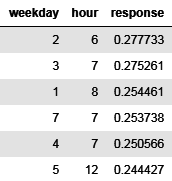

In [26]:
from IPython.display import Image, display
display(Image(filename='imgs/Naive.png', embed=True))

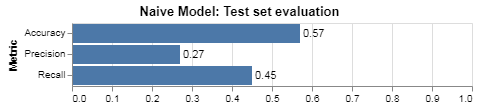

In [27]:
from IPython.display import Image, display
display(Image(filename='imgs/NaiveModel.png', embed=True))

### <i>0.2 Semi-personalized descriptive model</i>

As an extension for model 0.1 I decided to make use of historical opening times for each customer who opened more than 3 emails (threshold chosen arbitrarily). Logic then follows the model 0.1. 

In [ ]:
# for each test item
    # check if it is customer's mode hour for the weekday
        prediction = (1)
    # elif it is mode for weekday in the population
        prediction = (1)
    # else:    
        prediction = (0)

#### <i>0.2.1 Use case</i>

Main use case should be mainly for clients who oppose complex models with smaller gain and prefer understandable models. Can be very quick and super easy to implement solution if circumastances change or there is not time for training.

#### <i>0.2.2 Results</i>

Semi-personalized model clearly outperformed 0.1 Population based one and reached very good `Recall` value of `0.62`. On the other hand it was caused by overshooting positives based on `Precision` being `0.3`. This should be undesirable unless clients are insensitive to overload of emails (which I assume are not).

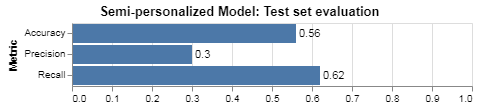

In [2]:
from IPython.display import Image, display
display(Image(filename='imgs/semi.png', embed=True))

### <i>Data preparation</i>

Motivation for following preprocessing steps were that first I wanted to develop a binomial regression model or more generally binary classification problem to obtain probability prediction. 
* I extracted important time attributes from unix timestamps as hour and weekday. 
* Unsubscribe clicks were removed
* Extraction of valueable information from all other historical events.For each training sample ie delivered email I extracted most upto date set of three statistics from each json. That being **time since last**, **count** and **mean difference** between sessions;purchases;opened/cliked emails;cart updates. This step caused serious overhead for my single machine setup but as we will see brought some benefits.


**<i>How was response created?<i>**
All  distinct delivered emails were included (there were some exact duplicated rows in the campaigns). Union of opened and proper clicked emails was created based on points above. Importantly my personal guess was that clicked is equivalently good and even better outcome than opened so this is also considered positive response. 
Then if email delivery was followed directly by opened/clicked event before next email was sent, instance is considered positive otherwise negative. Given that clicked action was not intended for usubscribe. This excludes clicked emails that were for usubscribe and opened/clicked which were not preceeded by delivery since we cannot use such case for the training (mainly start of the sample). Although latter case still impacts Naive model thus underlines its potential for new customers
Afterwards all mentioned features were mapped on each item considering all until then history of customer. Looking back I would surely include also mode email opening time for each customer.
Finally, I decided to not create dummy variables for hour and weekday since methods I used (Random Forests, Decision Trees) are very good at handling any types of data.


Note: If we would like to optimize email send times for purchase frequency maximization, only some changes would need to be done in preprocessing. Basically positive instance would be any delivered email which was directly followed by open/click (this was done above) and! that was directly followed by purchase item. Obviously exception can be raised that customer can be impacted also by historical events but that is exactly what I already tried to include in the dataset. Other than that I would iterate over similar methods used for open/click optimization.

Note (2): During whole analysis I am considering delivered to be an identifier of proper training instance. Reason being, if we know when is the optimal time customer should recieve his email we can then optmizie for enqueue time ourselves.

#### <i>Unbalanced classes</i>

* `Not Opened` : 47412
* `Opened` : 15113

Since I was dealing with seriously unbalanced problem I should decide how to treat the training phase. 
First decision was that I will use ROC AUC, precission and recall as evaluation metrics since metrics as accuracy are suboptimal in ubalanced problems. 
In order to balance classes I was left with few options as under-/over-sampling of training data or using class weights directly in training. I decided to go with `SMOTE (Synthetic Minority Over-sampling Technique)` which served me very well in the past. Difference is that not only bootstrapping but number of nearest neighbours is used to construct synthetic samples.Aswell it is combination of under/oversampling.

### <i>Training</i>

In order to preserve good generalization of my model I decided to use `StratifiedShuffleSplitCV` for training phase. This method on the contrary to other cross-validation techniques do not guarantee different splits but choose them at random. Shuffle technique is mainly used since it helps to train more effectively on smaller dataset. Stratified approach helps to maintain percentage of samples for each class. I used `5 splits` with `0.33 test size`.

## <i>1.Binomial Regression</i>

### <i>Motivation</i>

After naive model I decided to define my problem as follows. <b><i>Given current hour,weekday and all 4 combinations of aggregates last,count,mean_diff what is probability of customer opening this email</b></i>. This may sound as surrogate answer to initial problem since clearly goal is to predict optimal time. Although this setting allows us in production to either make max over different timestamps (which are currenlty aggregated on hourly basis) of our choice to see which distribution has overall higher expectation or higher peeking modes. Or we can decide based on threshold of probability for each customer to send email on individual basis.

### <i>1.1 Decision Tree</i>

First method for the task was `Decision Tree Classifier`. It is non-parametric supervised method which is trying to divide whole feature space to distinct areas by simple rules. Main benefits are interpretability (can be visualized), requires little preprocessing of data types, efficiently trainable and can be easily validated using statistical tests.

Tree was trained on weekday and hour only as features since it serves as baseline only with limited depth.

In [5]:
#DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
#            max_features=None, max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
#            splitter='best')

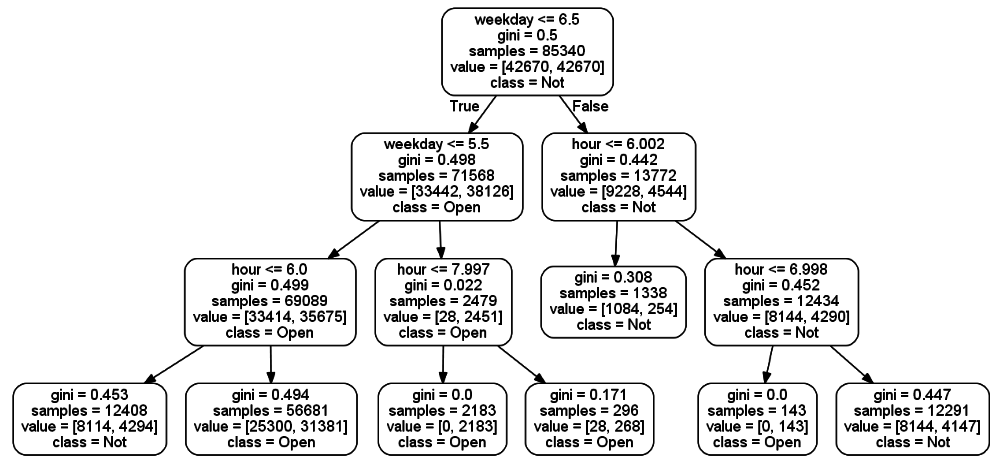

In [21]:
from IPython.display import Image, display
display(Image(filename='imgs/tree.png', embed=True))

Above we can see what decision rules are followed throughout the tree. Best distinction on first layer offers weekday being smaller than Saturday and important distinction on 6am hour in layer 2. As an example we can read it as if the time for we are evaluating the model is earlier or equal than Saturday and hour is earlier or equal than 6am our model alway predicts 'Not Opening' class. Overall seems like Saturday and 6-7am plays huge role in decision process here.

#### <i>1.1.1 Use case</i>

Given that we used only weekday and hour I suggest this model being used only for new customers without any other history but we can already see considerable performance improvement over if-then frequency based model. On the other end points outlined in the method description may suggest that a little bit worse performance than complicated ensemble methods could be equaled by interpretability and efficiency of training.

#### <i>1.1.2 Results</i>

We can see similar but slightly worse performance in `Precision` (and Accuracy) although `12% better Recall` which means decision Tree is way better at capturing all Positives than Naive approach. I would go with this model mainly if client don't want to miss out on all possible positive responses. Though it needs to be said that this was heavily toy Decision Tree used mianly for visual and interpretability purposes. It could serve well as bridge between boosted ensembles since it is their part.

In [13]:
from IPython.display import HTML, display
display(HTML("<img src='imgs/DT.png'>"))

### <i>1.2 Random Forest</i>

Second method was `Random Forest Classifier` where each Decision tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. It slightly increases bias (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model. That is also reason I decided to use Random Forest. Additionally you are also able to visualize its particular Decision Trees as above.

In [ ]:
#Pseudocode of training and hyperparameter optimization
clf_rf = RandomForestClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

rf_param_grid = {
                  'n_estimators': np.arange(20, 400, 20),
                 }

random_grid_rf_CV = RandomizedSearchCV(clf_rf,
                                        rf_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)
random_grid_rf_CV.fit(X_train_sm, Y_train_sm)

print(random_grid_rf_CV.best_score_) #0.9375684750516371
print(random_grid_rf_CV.best_params_) #{'n_estimators': 380}

This time I decided to use all mentioned features and take advantage of ability to deal with different data types and scales which are present in our dataset. It is also very efficiently trainable.

#### <i>1.2.1 Use case</i>

I suggest using Random Forest for more complicated cases when we already have additional information about customer such as email frequency, email mean difference and such. For the future more hyperparamater tunign could have bring benefits over current performance.

#### <i>1.2.2 Results</i>

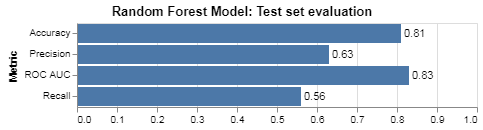

In [29]:
from IPython.display import Image, display
display(Image(filename='imgs/rf_perf.png', embed=True))

Although we lost a little bit of interpretability with comparison to Decision Tree we may see serious predictive improvement. ROC curve suggest that Forest is way better at capturing True Positive Rate versus False Positive Rate. This is very useful baseline metric as it captures recall and sensitivity at the same time prior to specifying costs of different errors. In addition we can present interesting results from Feature Importance table where email history metric appear to be most important for models' predictions. On the other hand purchase history seems to be not so important which may suggest there is a difference between people which open email and which buy things. In any case interesting input fo rfurther analysis and also for bonus task of optimizing for purchases frequency.

If I would be able to demonstrate to client how Decision Tree works (given he will be interested obviously) and show him feature importance of RF I think performance of (Boosted) Random Forest makes it most serious competitor among tried models.

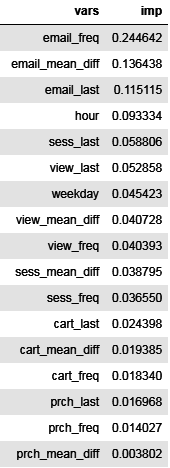

In [30]:
from IPython.display import Image, display
display(Image(filename='imgs/rf_imp.png', embed=True))

### <i>1.3 Boosted trees - XGBoost</i>

XGBoost is fast and accurate implementation of `Gradient Boosted Trees`. Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. Both biggest advantages of XGBoost are very important for real life bussiness case such as this since we are able to perform training really quickly and achieve good results at the same time.

In [ ]:
#Pseudocode of training and hyperparameter optimization
XGB_Classifier = xgboost.XGBClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

xgb_param_grid = {
                  'max_depth': np.arange(2, 40, 2),
                  'learning_rate': np.arange(0.2, 2, 0.2),
                  'n_estimators': np.arange(20, 400, 20),
                  'reg_alpha': np.arange(0, 2, 0.2),
                  'reg_lambda': np.arange(0, 2, 0.2)
                 }

random_grid_XGB_CV = RandomizedSearchCV(XGB_Classifier,
                                        xgb_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)
random_grid_XGB_CV.fit(X_train_sm, Y_train_sm)

print(random_grid_XGB_CV.best_score_) #0.938320474250865
print(random_grid_XGB_CV.best_params_)#{'reg_lambda': 1.8, 'reg_alpha': 1.6, 
    #'n_estimators': 260, 'max_depth': 32, 'learning_rate': 0.4}

#### <i>1.3.1 Use case</i>

Mainly in cases where classic Random Forest take too long to train or do not perform sufficiently enough. business context is faster predictions and time is money.

#### <i>1.3.2 Results</i>

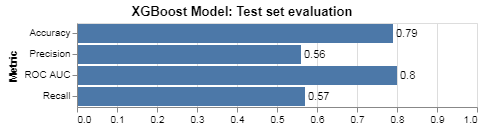

In [32]:
from IPython.display import Image, display
display(Image(filename='imgs/xgb_perf.png', embed=True))

Unfortunately XGBoost does not overcome classic Random Forest in nearly any metric. Although XGBoost was trained longer for now since more parameters were optimized. For now I would prefer Random Forest if we won't find out it doesn't generalize good enough.

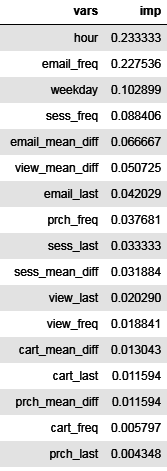

In [31]:
from IPython.display import Image, display
display(Image(filename='imgs/xgb_imp.png', embed=True))

### <i>1.4 LightGBM</i>

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency
* Lower memory usage
* Better accuracy
* Parallel and GPU learning supported
* Capable of handling large-scale data

All above makes it competitor to Random Forest and XGBoost. Historically perform very similarly to XGBoost although better on some problems.

In [ ]:
#Pseudocode of training and hyperparameter optimization
CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=None)

lightgbm_param_grid = {
                  'max_depth': np.arange(2, 40, 2),
                  'learning_rate': np.arange(0.2, 2, 0.2),
                  'n_estimators': np.arange(20, 400, 10),
                  'reg_alpha': np.arange(0, 2, 0.2),
                  'reg_lambda': np.arange(0, 2, 0.2),
                  'max_bin': np.arange(300, 600, 5),
                  'num_leaves':np.arange(31,60,1)
                 }

estimator = lightgbm.LGBMClassifier(application='binary',objective='binary',metric='roc_auc',is_unbalance='false',boosting= 'gbdt')

random_grid_GBM_CV = RandomizedSearchCV(estimator,
                                        lightgbm_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)

random_grid_GBM_CV.fit(X_train_sm, Y_train_sm)

print('Best score found by random search are:', random_grid_GBM_CV.best_score_) #0.9284318191054031
print('Best parameters found by random search are:', random_grid_GBM_CV.best_params_)# {'reg_lambda': 0.6000000000000001, 
#'reg_alpha': 0.2, 'num_leaves': 44, 'n_estimators': 140, 'max_depth': 30, 'max_bin': 475, 'learning_rate': 0.8}

#### <i>1.4.2 Results</i>

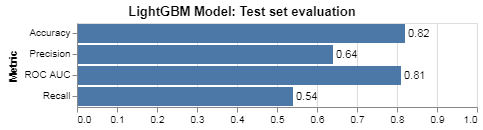

In [33]:
from IPython.display import Image, display
display(Image(filename='imgs/gbm_perf.png', embed=True))

We can see comparable performance to Random Forest and better than XGBoost. Which makes it suitable in case we would need faster training time in production.

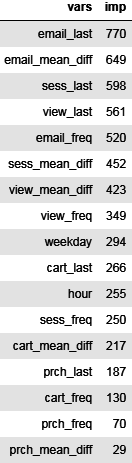

In [34]:
from IPython.display import Image, display
display(Image(filename='imgs/gbm_imp.png', embed=True))

## <i>1.5 Conclusion</i>

<i>**Production use.**</i>
    Overall set of binary classification models (1.x) could be very useful in business cases when we already have a campaign we want to send out while optimizing over some discrete set of date/times. After input from client about desired timeframe we could very easily iterate over pre-selected (with some domain knowledge) hours and provide multiple ranked classes based on probability assigned by our model.By this technique we could very easily overcome shortcomings of regression for which it could be harder limit outputs or provide multiple recommendations.

<i>**Model selection.**</i>
For such task, taking into account time spend training and performance, model `1.2 Random Forest` would be my model of choice in general. For new unseen customers I would consider using `1.4 LightGBM` since it is mostly dependent on hour weekday and session metrics (which usually come first) or `0.2 Semi personalized descriptive model` which shortcoming of overshooting potitive predictions could have cause less harm since new customers have no history of being overload by our emails.

### <i>1.6 Future improvements</i>

In order to enhance current models I would start by 
* Use different <b><i>weights for different days of the month</i></b> - days right after salaries being paid could enhance open rates
* Train on longer time window in order to <b><i>use seasonality trends</b></i> - this I didn't work on since I was equiped by 2 months worth of data only
* Incorporating useful <b><i>linear combinations of features</b></i>  - since this is the area Random Forest are mostly lacking behind other Machine Learning methods (methods like Support Vector Classifier could be used for this)
* Adding different kinds of <b><i>new aggregates</b></i> - current number of items in cart comes to my mind as a first
* <b><i>Feature selection</b></i> based on Random Forest - purchase_item aggregates appeared to have very little impact
* Examine <b><i>impact of high frequency campaigns</b></i> on unsubscring clients
* Use <b><i>treeinterpreter</b></i> to  analyze misclassed predictions of Random Forests - otherwise analyze random trees makes little since there is stochasticity in number of features considered in each split (usually sqrt(features))

### <i><b>1.6.5 Feature Selection and Interaction Terms</b></i>

Based on best performing model 1.2 Random Forest and its feature importance I atempted to decrease variance of the estimator by selecting most important features (conditioned by arbitrary value `0.045`) abd then fit Logistic Regression Classifier and Random Forest again.

#### 1.6.5.1 Logistic Regression

Logistic regression with selected features was able to clearly outperform  (in terms of `Recall` & `Precision`) other easily explainable models from category 0.x and Decision Tree and so I would additionally add it as best option in terms of interpretability since we are able to see coefficients for each and every variable.

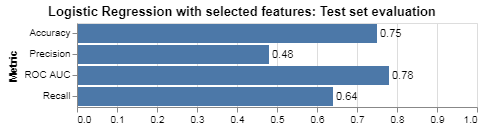

In [3]:
from IPython.display import Image, display
display(Image(filename='imgs/logit.png', embed=True))

Unfortunately I was not able to improve performance of the Random Forest by performing `feature selection` which probably should be done on more granular basis taking into account more domain knowledge.

At the same time performanace didn't improve by including automatic `interaction terms` and so I do not share these results but can be viewed in `1. Binary classification.ipynb.`